# 预测新图像

使用训练好的图像分类模型，对新图像文件进行预测。

同济子豪兄：https://space.bilibili.com/1900783

[代码运行云GPU环境](https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1)：GPU RTX 3060、CUDA v11.2

## 导入工具包

In [10]:
import torch
import torchvision
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
import matplotlib
matplotlib.rc("font",family='cmb10') # 中文字体
from PIL import Image, ImageFont, ImageDraw

# 导入中文字体，指定字号
font = ImageFont.truetype('SimHei.ttf', 32)
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()

from torchvision import transforms
# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])
model = torch.load('checkpoints/resnet50/fc/best-0.867.pth')
model = model.eval().to(device)

In [11]:
idx_to_labels

{0: '云',
 1: '仓鼠',
 2: '兔子',
 3: '兰花',
 4: '割草机',
 5: '向日葵',
 6: '城堡',
 7: '大海',
 8: '大象',
 9: '女人',
 10: '女孩',
 11: '小婴儿',
 12: '山',
 13: '巴士',
 14: '平原',
 15: '床',
 16: '恐龙',
 17: '房屋',
 18: '拖拉机',
 19: '摩天大楼',
 20: '摩托车',
 21: '时钟',
 22: '有轨电车',
 23: '杯子',
 24: '松树',
 25: '松鼠',
 26: '枫树',
 27: '柳树',
 28: '桌子',
 29: '桥',
 30: '梨',
 31: '棕榈树',
 32: '森林',
 33: '椅子',
 34: '橘子',
 35: '橡树',
 36: '比目鱼',
 37: '毛虫',
 38: '水族馆鱼类',
 39: '水濑',
 40: '沙发',
 41: '浣熊',
 42: '海狸',
 43: '海豚',
 44: '海豹',
 45: '海龟',
 46: '火箭',
 47: '火车',
 48: '灯',
 49: '熊',
 50: '牛',
 51: '狐狸',
 52: '狮子',
 53: '狼',
 54: '玫瑰',
 55: '瓶子',
 56: '甜椒',
 57: '甲虫',
 58: '电视',
 59: '电话',
 60: '男人',
 61: '男孩',
 62: '皮卡',
 63: '盘子',
 64: '碗',
 65: '箱子',
 66: '罂粟',
 67: '老虎',
 68: '老鼠',
 69: '自行车',
 70: '臭鼬',
 71: '苹果',
 72: '蘑菇',
 73: '蛇',
 74: '蜗牛',
 75: '蜘蛛',
 76: '蜜蜂',
 77: '蜥蜴',
 78: '蝴蝶',
 79: '螃蟹',
 80: '蟑螂',
 81: '蠕虫',
 82: '衣柜',
 83: '袋鼠',
 84: '豪猪',
 85: '豹',
 86: '负鼠',
 87: '郁金香',
 88: '金属罐',
 89: '键盘',
 90: '马路',
 91:

In [34]:
img_path = 'test_img/2.png'
img_pil = Image.open(img_path).convert('RGB')
np.array(img_pil).shape

(602, 408, 3)

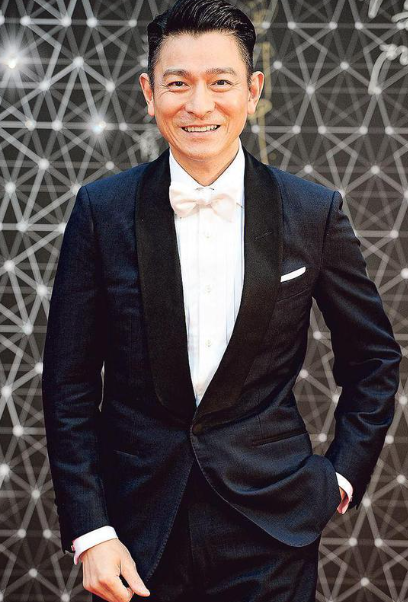

In [35]:
img_pil

## 预处理、前向预测

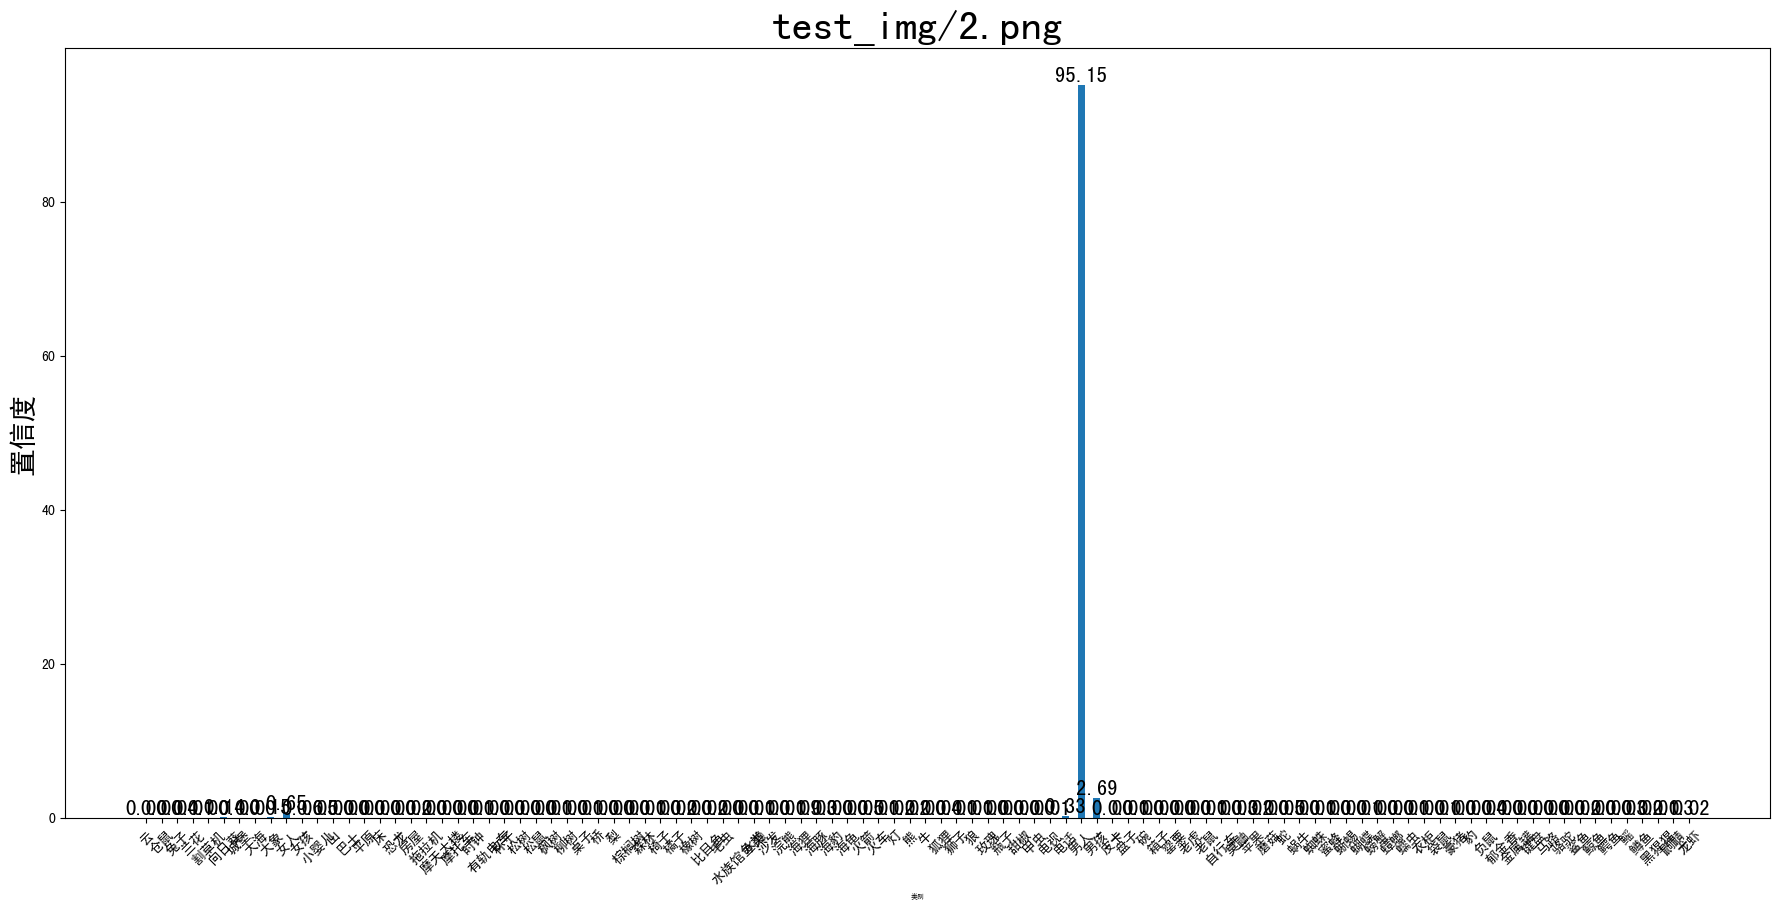

In [36]:
input_img = test_transform(img_pil) # 预处理
input_img = input_img.unsqueeze(0).to(device)
pred_logits = model(input_img) 
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算
plt.figure(figsize=(22, 10))

x = idx_to_labels.values()
y = pred_softmax.cpu().detach().numpy()[0] * 100
width = 0.45 # 柱状图宽度

ax = plt.bar(x, y, width)

plt.bar_label(ax, fmt='%.2f', fontsize=15) # 置信度数值
plt.tick_params(labelsize=10) # 设置坐标文字大小

plt.title(img_path, fontsize=30)
plt.xticks(rotation=45) # 横轴文字旋转
plt.xlabel('类别', fontsize=5)
plt.ylabel('置信度', fontsize=20)
plt.show()

## 置信度最大的前 n 个结果

In [37]:
n = 10
top_n = torch.topk(pred_softmax, n) # 取置信度最大的 n 个结果
pred_ids = top_n[1].cpu().detach().numpy().squeeze() # 解析出类别
confs = top_n[0].cpu().detach().numpy().squeeze() # 解析出置信度
draw = ImageDraw.Draw(img_pil)
for i in range(n):
    class_name = idx_to_labels[pred_ids[i]] # 获取类别名称
    confidence = confs[i] * 100 # 获取置信度
    text = '{:<15} {:>.4f}'.format(class_name, confidence) # 保留 4 位小数
    print(text)
    
    # 文字坐标，中文字符串，字体，rgba颜色
    draw.text((50, 100 + 50 * i), text, font=font, fill=(255, 0, 0, 1))

男人              95.1504
男孩              2.6888
女人              0.6468
电话              0.3255
大象              0.1514
向日葵             0.1379
海狸              0.0933
女孩              0.0627
火箭              0.0540
小婴儿             0.0495


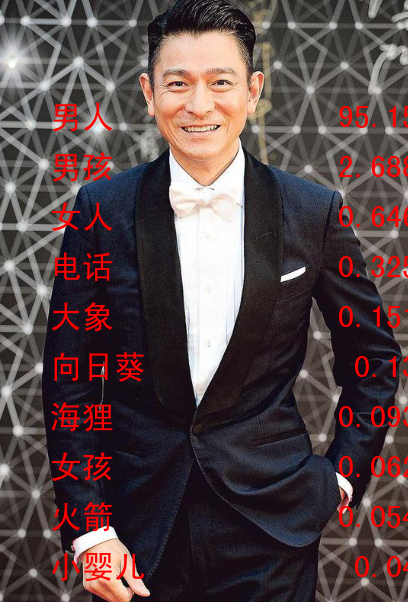

In [38]:
img_pil